In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import vtk
from vtkmodules.util import numpy_support
from data.data import fitTransPipeline
from cfg.configs import Config
from train import load_checkpoint
from eval.util import mse, mae
import matplotlib.pyplot as plt
from util.phys2comp import CurviInterpCell

%load_ext autoreload
%autoreload 2

In [2]:
# 0-100
# -150-100
# 200-275

data_path = "../test/final/data/bc80-45000-down.vts"
vtkSGR = vtk.vtkXMLStructuredGridReader()
vtkSGR.SetFileName(data_path)
vtkSGR.Update()
vtkSG = vtkSGR.GetOutput()
print(vtkSG.GetDimensions())
print(vtkSG.GetExtent())
print(vtkSG.GetBounds())

(88, 51, 21)
(0, 87, 0, 50, 0, 20)
(0.0, 696.0, -250.0, 150.0, 0.7504535071217414, 429.4370158281313)


In [169]:
dims = np.array([21, 51, 88])
z,y,x = np.meshgrid(
  np.linspace(0, 1, dims[0]),
  np.linspace(0, 1, dims[1]),
  np.linspace(0, 1, dims[2]),
  indexing="ij"
)
xyz = np.concatenate([z[...,None], y[...,None], x[...,None]], axis=-1)

In [124]:
def getPhysRays(numDepths, planeIdx, imgSize):
  fieldExtents = np.array([1, 100, -150, 100, 200, 275])
  
  depthPlaneIdx = 3 - planeIdx[0] - planeIdx [1]

  p1min = fieldExtents[planeIdx[0]*2]
  p1max = fieldExtents[planeIdx[0]*2+1]
  p2min = fieldExtents[planeIdx[1]*2]
  p2max = fieldExtents[planeIdx[1]*2+1]
  dmin = fieldExtents[depthPlaneIdx*2]
  dmax = fieldExtents[depthPlaneIdx*2+1]

  p1,p2 = np.meshgrid(
    np.linspace(p1min, p1max, imgSize),
    np.linspace(p2min, p2max, imgSize),
    indexing='ij'
  )
  print(p1.shape)
  p1 = np.broadcast_to(p1[...,None], (imgSize, imgSize, numDepths))
  p2 = np.broadcast_to(p2[...,None], (imgSize, imgSize, numDepths))
  depths = np.linspace(dmin, dmax, numDepths).reshape(1, 1, -1)
  depths = np.broadcast_to(depths, (imgSize, imgSize, numDepths))

  coords = [0]*3
  coords[planeIdx[0]] = p1
  coords[planeIdx[1]] = p2
  coords[depthPlaneIdx] = depths
  rays = np.stack(coords, -1)
  return rays

def hasRow(arr, q):
  return np.equal(arr, q).all(1).any()

def isInBox(coord, bbox=np.array([[1, 100], [-150, 100], [200, 275]])):
  xIn = np.logical_and(coord[...,0] > bbox[0,0], coord[...,0] < bbox[0,1])
  yIn = np.logical_and(coord[...,1] > bbox[1,0], coord[...,1] < bbox[1,1])
  zIn = np.logical_and(coord[...,2] > bbox[2,0], coord[...,2] < bbox[2,1])
  return np.logical_and(np.logical_and(xIn, yIn), zIn)

# given a list of inbox indices and a 3d vtx idx of a cell
# check if all cell vtx idx is in the bbox
def isCellInBox(inboxIdx, idx):
  for i in range(2):
    for j in range(2):
      for k in range(2):
        tmp = idx.copy()
        tmp[0] += i
        tmp[1] += j
        tmp[2] += k
        isIn = hasRow(inboxIdx, tmp)
        # print(tmp, isIn)
        if not isIn:
          return False
  return True

(4, 4)


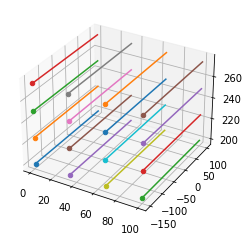

In [35]:
imgSize = 4
numDepths = 64
rays = getPhysRays(numDepths, [0,2], imgSize)
rays = rays.reshape(imgSize*imgSize, numDepths, 3)

fig = plt.figure()
ax = plt.axes(projection='3d')
for ray in rays:
  ax.scatter(ray[0,0], ray[0,1], ray[0,2])
  ax.plot(ray[:,0], ray[:,1], ray[:,2])
plt.show()

In [10]:
sirencfg = Config("vls_siren_aug.yaml")
ds = sirencfg.get_dataset()

Original Phys2Comp dataset dimension: [21 51 88]
Augmented Phys2Comp dataset dimension: [61, 151, 262]
transforming inputs


In [4]:
impcfg = Config("nn_vls_lg.yaml")

sirencfg = Config("nn_vls_siren.yaml")
rescfg = Config("nn_vls_res.yaml")
attncfg = Config("nn_vls_attn.yaml")
densecfg = Config("nn_vls_dense.yaml")

mlp = load_checkpoint("log/mlp.pt", impcfg)
siren = load_checkpoint("log/siren.pt", sirencfg)
res = load_checkpoint(  "log/res.pt",   rescfg)
attn = load_checkpoint( "log/attn.pt",  attncfg)
dense = load_checkpoint("log/dense.pt", densecfg)

ds = sirencfg.get_dataset()

ckpts = [mlp, siren, res, attn, dense]
models = [ckpt['model'] for ckpt in ckpts]
names = ["mlp", "siren", "res", "attn", "dense"]

transforming inputs


In [5]:
# find training points in bbox
coord = ds.phys.reshape(-1, 3)
inboxIdx = isInBox(coord)
inCoord = ds.phys_prep[inboxIdx]
gtInCoord = ds.comp_prep[inboxIdx]

rays = getPhysRays(8, [0,2], 8)
rays = torch.Tensor(ds.inpp.transform(rays.reshape(-1, 3)))

phys_input = inCoord
gt = gtInCoord
gt = np.array(gt)

comp = ds.comp_prep.numpy()
for i in range(len(models)):
  model = models[i]
  model.eval()
  with torch.no_grad():
    pred = model(phys_input)
  pred = pred.numpy()
  # print(f"***************************** {names[i]} *****************************",
  #       f"MSE: {mse(pred, gt):e}, MAE: {mae(pred, gt):e}")
  for i in range(10):
    idx = np.random.choice(pred.shape[0])
    print(gt[idx], pred[idx])
  print()

(8, 8)
[ 0.2        0.6       -0.9310345] [ 0.19253613  0.6028678  -0.93114793]
[ 0.         0.16      -0.9770115] [-0.00142985  0.16496025 -0.977417  ]
[ 0.3        0.32      -0.7241379] [ 0.29421645  0.32191813 -0.72389305]
[ 0.4         0.         -0.77011496] [ 0.39725718  0.00156465 -0.7703724 ]
[-0.2        -0.28       -0.81609195] [-0.20555878 -0.27680305 -0.8161733 ]
[ 0.3       -0.04      -0.7241379] [ 0.29777867 -0.03789876 -0.7231627 ]
[-0.2        -0.36       -0.83908045] [-0.20265107 -0.3577254  -0.8380535 ]
[-0.1        0.48      -0.9770115] [-0.10321038  0.48210904 -0.97740126]
[ 0.1       -0.4       -0.7241379] [ 0.09345911 -0.3965791  -0.7237824 ]
[ 0.2        -0.28       -0.79310346] [ 0.1976345  -0.27957085 -0.7933093 ]

[-0.4       0.36     -0.954023] [-0.40031403  0.35923165 -0.9556267 ]
[-0.1        0.6       -0.9310345] [-0.10636231  0.5988891  -0.93145597]
[ 0.4        0.72      -0.7241379] [ 0.3978293   0.71780634 -0.72567123]
[-0.1      -0.16     -0.954023] [-

In [127]:
def model_infer_plot(phys_rays, comp_rays, in_trans, ckpt, model_name=None):
  # physical ray visulization
  fig = plt.figure(figsize=(15, 3))
  ax1 = fig.add_subplot(1, 6, 1, projection='3d')
  for ray in phys_rays:
    ax1.scatter(ray[0,0], ray[0,1], ray[0,2])
    ax1.plot(ray[:,0], ray[:,1], ray[:,2])
  plt.title(f"physical rays")

  ax3 = fig.add_subplot(1, 6, 2, projection='3d')
  for ray in comp_rays:
    ax3.scatter(ray[0,0], ray[0,1], ray[0,2])
    ax3.plot(ray[:,0], ray[:,1], ray[:,2])
  plt.title("comp rays")

  # network inference
  in_rays = in_trans.transform(phys_rays.reshape(-1, 3)) # preprocessing
  in_rays = torch.Tensor(in_rays)
  with torch.no_grad():
    model = ckpt['model']
    model.eval()
    out_rays = model(in_rays)
  out_rays = out_rays.cpu().numpy().reshape(rays.shape)

  ax2 = fig.add_subplot(1, 6, 3, projection='3d')
  for ray in out_rays:
    ax2.scatter(ray[0,0], ray[0,1], ray[0,2])
    ax2.plot(ray[:,0], ray[:,1], ray[:,2])
  plt.title(f"predicted comp rays {model_name}")
  plt.show()
  print(f"MSE: {mse(comp_rays, out_rays)}  MAE: {mae(comp_rays, out_rays)}")

def models_infer_plot(phys_rays, comp_rays, in_trans, ckpts, model_names=None):
  # physical ray visulization
  num_models = len(ckpts)
  fig = plt.figure(figsize=(20, 3))
  ax1 = fig.add_subplot(1, 2+num_models, 1, projection='3d')
  for ray in phys_rays:
    ax1.scatter(ray[0,0], ray[0,1], ray[0,2])
    ax1.plot(ray[:,0], ray[:,1], ray[:,2])
  plt.title(f"physical rays")

  ax3 = fig.add_subplot(1, 2+num_models, 2, projection='3d')
  for ray in comp_rays:
    ax3.scatter(ray[0,0], ray[0,1], ray[0,2])
    ax3.plot(ray[:,0], ray[:,1], ray[:,2])
  plt.title("comp rays (GT)")


  # network inference
  in_rays = in_trans.transform(phys_rays.reshape(-1, 3)) # preprocessing
  in_rays = torch.Tensor(in_rays)

  for i in range(len(ckpts)):
    with torch.no_grad():
      model = ckpts[i]['model']
      model.eval()
      out_rays = model(in_rays)
    out_rays = out_rays.cpu().numpy().reshape(rays.shape)

    ax2 = fig.add_subplot(1, 2+num_models, 3+i, projection='3d')
    for ray in out_rays:
      ax2.scatter(ray[0,0], ray[0,1], ray[0,2])
      ax2.plot(ray[:,0], ray[:,1], ray[:,2])
    plt.title(f"predicted-{model_names[i]}")
  plt.show()
  fig.clear()

def models_infer_plot_scatter(phys_rays, in_trans, ckpts, model_names=None, gt=None):
  fig = plt.figure(figsize=(20, 3))
  num_models = len(ckpts)
  
  phys_rays = phys_rays.reshape(-1, 3)
  ax1 = fig.add_subplot(1, 1+num_models, 1, projection='3d')
  # ax1.set_xlim3d(0, 101)
  # ax1.set_ylim3d(-151, 101)
  # ax1.set_zlim3d(199, 276)
  ax1.scatter(phys_rays[:,0], phys_rays[:,1], phys_rays[:,2])
  plt.title(f"physical rays")  
  
  # network inference
  in_rays = in_trans.transform(phys_rays.reshape(-1, 3)) # preprocessing
  in_rays = torch.Tensor(in_rays)

  for i in range(len(ckpts)):
    with torch.no_grad():
      model = ckpts[i]['model']
      model.eval()
      out_rays = model(in_rays)
    out_rays = out_rays.cpu().numpy()
    # print(f"mean: {out_rays.mean(0)}, max: {out_rays.max(0)}, min: {out_rays.min(0)}")

    ax2 = fig.add_subplot(1, 1+num_models, 2+i, projection='3d')
    # ax2.set_xlim3d(-1.1, 1.1)
    # ax2.set_ylim3d(-1.1, 1.1)
    # ax2.set_zlim3d(-1.1, 1.1)
    ax2.scatter(out_rays[:,0], out_rays[:,1], out_rays[:,2])
    if gt is not None:
      ax2.scatter(gt[:,0], gt[:,1], gt[:,2], marker="v")
    # print(out_rays)
    plt.title(f"predicted-{model_names[i]}")
  plt.show()
  fig.clear()
  
def models_infer(phys_rays, in_trans, ckpts, model_names=None, gt=None):
  in_rays = in_trans.transform(phys_rays.reshape(-1, 3)) # preprocessing
  in_rays = torch.Tensor(in_rays)
  
  for i in range(len(ckpts)):
    with torch.no_grad():
      model = ckpts[i]['model']
      model.eval()
      out_rays = model(in_rays)
    out_rays = out_rays.cpu().numpy()
    if gt is not None:
      print(f"{model_names[i]} pred: {out_rays} MAE: {mae(out_rays, gt)} gt: {gt}")


In [163]:
# class RegularGrid:
#   def __init__(self, dims, scalar_field):
#     self.dims = dims
#     self.scalar_field = np.array(scalar_field).reshape(*dims, 1)
  
#   def get_value(self, coord):
#     coord = np.floor(coord)
#     coord = np.where(coord == (self.dims-1), coord, coord - 1)


# SCIPY lerp
from scipy.interpolate import RegularGridInterpolator

physField = RegularGridInterpolator(
  (np.arange(dims[0]), np.arange(dims[1]), np.arange(dims[2])),
  ds.phys
)

In [170]:
dims = np.array([21, 51, 88])
dim_auged = dims*3 - 2

In [185]:
dims = np.array([21, 51, 88])
dim_auged = dims*3 - 2
sample_points = np.meshgrid(
  np.linspace(0, dims[0]-1, dim_auged[0]),
  np.linspace(0, dims[1]-1, dim_auged[1]),
  np.linspace(0, dims[2]-1, dim_auged[2]),
  indexing='ij'
)
sample_points = np.stack(sample_points, -1)
phys_aug = physField(sample_points)

In [193]:
dim_auged

array([ 61, 151, 262])

In [180]:
sample_points_mat = sample_points.reshape(-1, 3)

In [184]:
physField(sample_points).reshape(-1, 3) == physField(sample_points_mat)

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       ...,
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [147]:
coord = np.array([1,2,3])
test = np.array([1,0,3])

In [148]:
np.where(coord == test, coord, coord-100)

array([  1, -98,   3])

In [7]:
coord = ds.phys.reshape(-1, 3)
inboxFlag = isInBox(coord)
inCoord = ds.phys_prep[inboxFlag]

inboxIdx = np.where(inboxFlag == 1)[0]
inboxIdx = np.unravel_index(inboxIdx, ds.dims)
inboxIdx = np.stack(inboxIdx, -1)
inboxIdx = np.concatenate([[[0,0,0]], inboxIdx], 0)

for i in range(2):
  for j in range(2):
    for k in range(2):
      tmp = [8, 40, 5]
      tmp[0] += i
      tmp[1] += j
      tmp[2] += k
      print(tmp, hasRow(inboxIdx, tmp))
print("Cell of lowest vtx idx [8, 40, 5] is inside the bbox of [1, 100], [-150, 100], [200, 275] (z,y,x axis)")

# # check every vtx insied bbox whether a cell has it as the lowest vtx is inside the bbox
# for i in inboxIdx:
#   print(i, isCellInBox(inboxIdx, i))

[8, 40, 5] True
[8, 40, 6] True
[8, 41, 5] True
[8, 41, 6] True
[9, 40, 5] True
[9, 40, 6] True
[9, 41, 5] True
[9, 41, 6] True
Cell of lowest vtx idx [8, 40, 5] is inside the bbox of [1, 100], [-150, 100], [200, 275] (z,y,x axis)


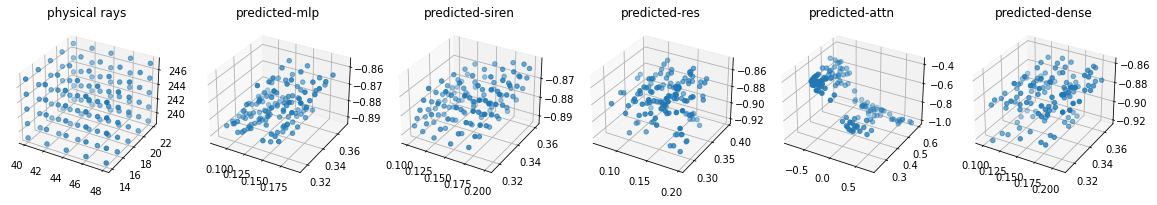

In [116]:
# 8 vtx of cell
idx = [11, 33, 5]
for i in range(2):
  for j in range(2):
    for k in range(2):
      idxi, idxj, idxk = idx
      # print([idxi+i, idxj+j, idxk+k], ds.phys[idxi+i, idxj+j, idxk+k])

idx = [11, 33, 5]
idxi, idxj, idxk = idx
physCoords = ds.phys[idx[0]:idx[0]+2, idx[1]:idx[1]+2, idx[2]:idx[2]+2]
compCoords = ds.comp[idx[0]:idx[0]+2, idx[1]:idx[1]+2, idx[2]:idx[2]+2]
midCoord = physCoords.reshape(8, 3).mean(0)
coords = physCoords.reshape(8, 3)

# # middle cube
numPoint = 5
x = np.linspace(40, 48, numPoint)
y = np.linspace(14, 22, numPoint)
z = np.linspace(239, 247, numPoint)
xyz = np.meshgrid(x,y,z, indexing="ij")
coords = np.stack(xyz, -1).reshape(-1, 3)

ray_input = np.vstack([coords, midCoord])
models_infer_plot_scatter(ray_input, ds.inpp, ckpts, names)

ray_input = np.vstack([coords, midCoord])
ray_input = ds.inpp.transform(ray_input.reshape(-1, 3))
ray_input = torch.Tensor(ray_input)
with torch.no_grad():
  cray = models[0](ray_input)
  cray = cray.cpu().numpy()
# print(cray)

# fig = plt.figure()
# ax2 = fig.add_subplot(projection='3d')
# ax2.scatter(cray[:-1,0], cray[:-1,1], cray[:-1,2])
# ax2.scatter(cray[-1,0], cray[-1,1], cray[-1,2])
# fig.show()

# fig = plt.figure()
# ax2 = fig.add_subplot(projection='3d')
# ax2.scatter(ray_input[:-1,0], ray_input[:-1,1], ray_input[:-1,2])
# ax2.scatter(ray_input[-1,0], ray_input[-1,1], ray_input[-1,2])
# fig.show()

In [71]:
low_vtx = compCoords.reshape(8, 3).min(0)
high_vtx = compCoords.reshape(8, 3).max(0)
init_guess = (low_vtx + high_vtx) / 2

phys = physCoords.reshape(2,2,2,3)
cic = CurviInterpCell(min_comp=low_vtx, max_comp=high_vtx, phys_coords=phys)

compGT = low_vtx + (high_vtx - low_vtx)*0.2
physTest, coeff = cic.comp2phys(compGT)
for p, c in zip(physCoords.reshape(-1, 3), tmpCompCoord.reshape(-1, 3)):
  print(f"{p}  {c}")
print(f"Testing point initial phys_est is {cic.comp2phys(init_guess)[0]}")
print(f"Testing point GT comp is {compGT}")
print(f"Testing point GT phys is {physTest}\n\n")

comp_est_newton = cic.phys2comp(physTest, maxiter=5, tol=1e-4)
comp_est_newton

[ 40.          14.         238.92995063]  [ 0.1         0.32       -0.88505747]
[ 48.          14.         235.25815101]  [ 0.2         0.32       -0.88505747]
[ 40.          22.         238.92995063]  [ 0.1         0.36       -0.88505747]
[ 48.          22.         235.25815101]  [ 0.2         0.36       -0.88505747]
[ 40.          14.         251.02692019]  [ 0.1         0.32       -0.86206897]
[ 48.          14.         247.42082034]  [ 0.2         0.32       -0.86206897]
[ 40.          22.         251.02692019]  [ 0.1         0.36       -0.86206897]
[ 48.          22.         247.42082034]  [ 0.2         0.36       -0.86206897]
Testing point initial phys_est is [ 44.          18.         243.15896054]
Testing point GT comp is [ 0.12        0.328      -0.88045977]
Testing point GT phys is [ 41.6         15.6        240.61761261]


comp low high: [ 0.1         0.32       -0.88505747] [ 0.2         0.36       -0.86206897]
phys_est: [ 44.          18.         243.15896054] comp: [-0.14

array([-4.23685641e+00, -9.55511600e+04, -9.56262330e+05])

mlp - Total MSE: 2.438405e-04 Total MAE: 1.081968e-02
siren - Total MSE: 1.654370e-05 Total MAE: 3.232950e-03
res - Total MSE: 6.431266e-04 Total MAE: 1.719083e-02
attn - Total MSE: 1.678500e-01 Total MAE: 3.139498e-01
dense - Total MSE: 1.430818e-04 Total MAE: 7.967514e-03


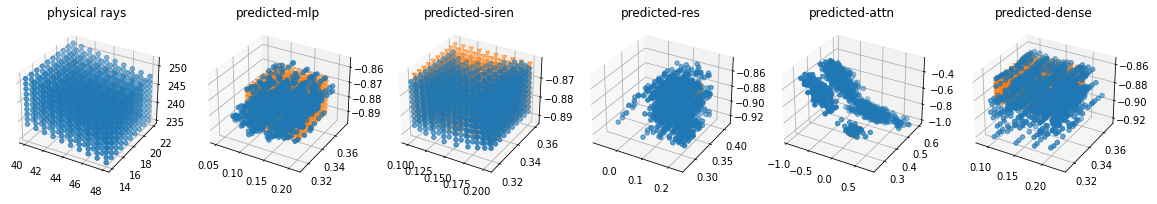

In [131]:
testComp = np.meshgrid(
  np.linspace(low_vtx[0], high_vtx[0], 10),
  np.linspace(low_vtx[1], high_vtx[1], 10),
  np.linspace(low_vtx[2], high_vtx[2], 10),
  indexing="ij"
)
testComp = np.stack(testComp, -1)
testCompMat = testComp.reshape(-1, 3)
testPhys = np.array([cic.comp2phys(c)[0] for c in testCompMat])
testPhysTorch = torch.Tensor(ds.inpp.transform(testPhys))
compSpacing = high_vtx - low_vtx



# models[1] is SIREN
for i in range(len(models)):
  predComp = models[i](testPhysTorch).detach().cpu().numpy()
  print(f"{names[i]} - Total MSE: {mse(predComp, testCompMat):e} Total MAE: {mae(predComp, testCompMat):e}")
  # for gt, pred in zip(testCompMat, predComp):
  #   # print(gt, pred, gt-pred, mae(gt, pred), mse(gt, pred))
  #   print(f"{gt} {pred} {(gt-pred) / compSpacing} {mae(gt,pred):e} {mse(gt,pred):e}")
  # print("*************************************************************************")
  # print("*************************************************************************")
  # print("*************************************************************************")
  # print("*************************************************************************")

models_infer_plot_scatter(testPhys, ds.inpp, ckpts, names, testCompMat, )


(4, 4)


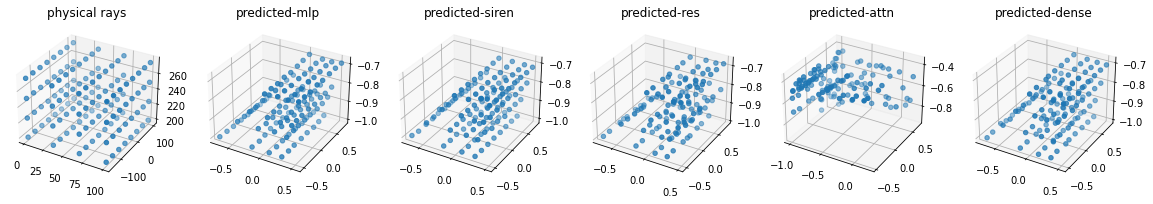

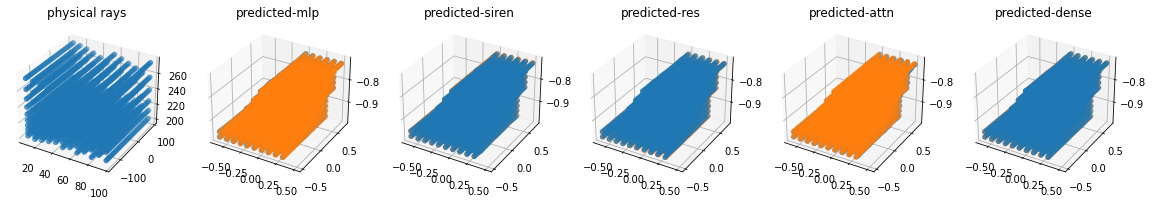

c:\Users\xiong\Envs\ml37\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


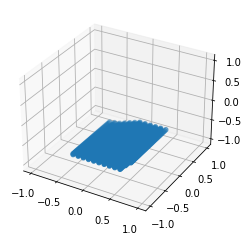

In [125]:
coord = ds.phys
inboxFlag = isInBox(coord)
inCoord = ds.phys[inboxFlag]
gtCoord = ds.comp[inboxFlag]

rays = getPhysRays(8, [0,2], 4)
# rays = inCoord
models_infer_plot_scatter(rays, ds.inpp, ckpts, names)

rays = inCoord[::]
gtRays = gtCoord[::]
models_infer_plot_scatter(rays, ds.inpp, ckpts, names, gtCoord)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim3d(-1.1, 1.1)
ax.set_ylim3d(-1.1, 1.1)
ax.set_zlim3d(-1.1, 1.1)
ax.scatter(gtRays[:,0], gtRays[:,1], gtRays[:,2])
fig.show()
# doesn't generalize very well
# neeed more training data
# need watch loss

In [122]:
inboxFlag = isInBox(coord)
inboxFlag

array([False, False, False, ..., False, False, False])

Grid dimension: [21 51 88]
************  from YZ Plane ************


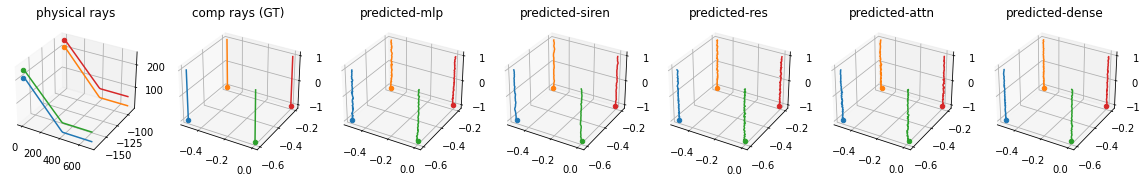

************  from XY Plane ************


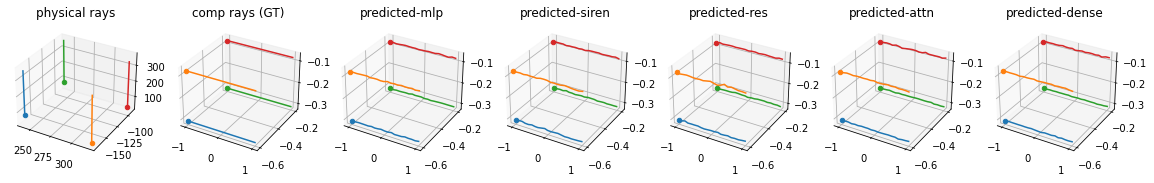

************  from XZ Plane ************


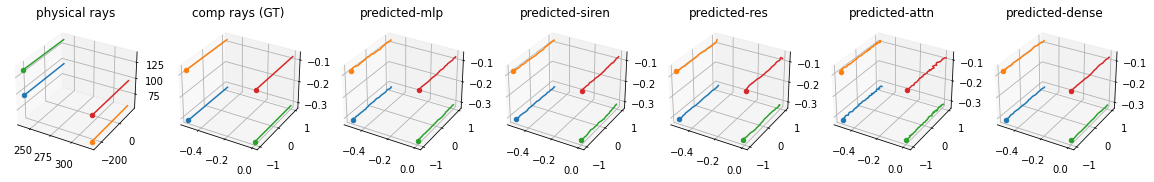

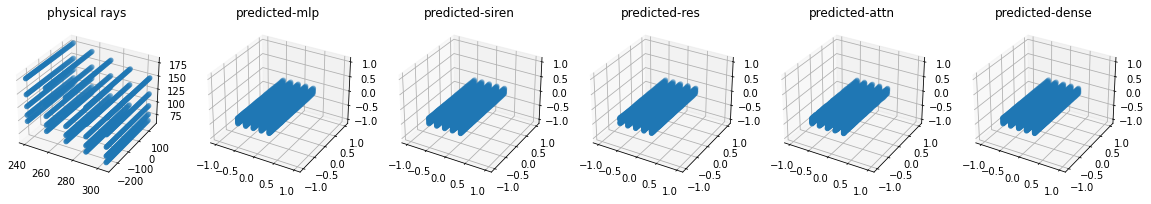

In [139]:
# generate physical rays
print("Grid dimension:", ds.dims)

phys = ds.phys.reshape(*ds.dims, 3)
comp = ds.comp.reshape(*ds.dims, 3)
# phys = getPhysRays(64, [0,2], 64)
# coord = ds.phys
# inboxIdx = isInBox(coord)
# inCoord = ds.phys_prep[inboxIdx]
# gtInCoord = ds.comp_prep[inboxIdx]

rays = phys[10:13, :, 20]
comp_rays = comp[10:13, :, 20]

yz_rays = phys[5:15:5, 10:30:10, :].reshape(4,-1,3)
xy_rays = phys[:, 10:30:10, 30:50:10, None].swapaxes(0, -2).squeeze().reshape(4, -1, 3)
xz_rays = phys[5:15:5, :, 30:50:10, None].swapaxes(1, -2).squeeze().reshape(4,-1,3)
yz_comp_rays = comp[5:15:5, 10:30:10, :].reshape(4,-1,3)
xy_comp_rays = comp[:, 10:30:10, 30:50:10, None].swapaxes(0, -2).squeeze().reshape(4, -1, 3)
xz_comp_rays = comp[5:15:5, :, 30:50:10, None].swapaxes(1, -2).squeeze().reshape(4,-1,3)

planes = ["YZ Plane", "XY Plane", "XZ Plane"]
plane_rays = [yz_rays, xy_rays, xz_rays]
plane_comp_rays = [yz_comp_rays, xy_comp_rays, xz_comp_rays]

for i in range(len(planes)):
  rays = plane_rays[i]
  comp_rays = plane_comp_rays[i]
  print(f"************  from {planes[i]} ************")
  models_infer_plot(rays, comp_rays, ds.inpp, ckpts, names)
  # for i in range(len(models)):
  #   model_infer_plot(rays, comp_rays, ds.inpp, ckpts[i], names[i])

rays = phys[5:15:2, :, 30:40:2]
models_infer_plot_scatter(rays, ds.inpp, ckpts, names)

# for i in range(len(rays[0])):
#   print(in_rays[i], out_rays[i])

Grid dimension: [21 51 88]
************  from YZ Plane ************


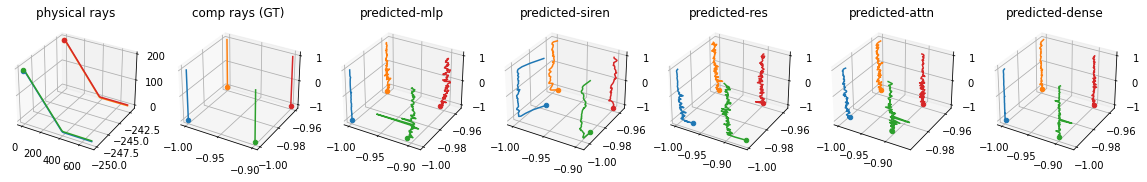

************  from XY Plane ************


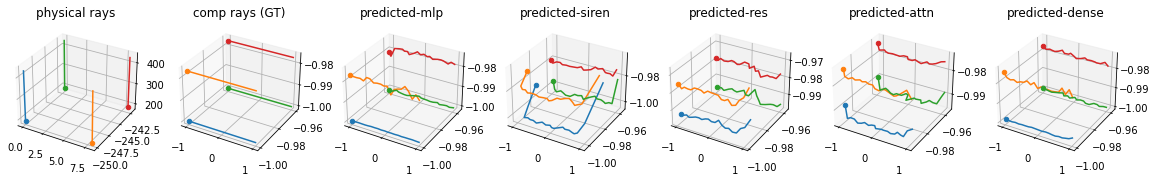

************  from XZ Plane ************


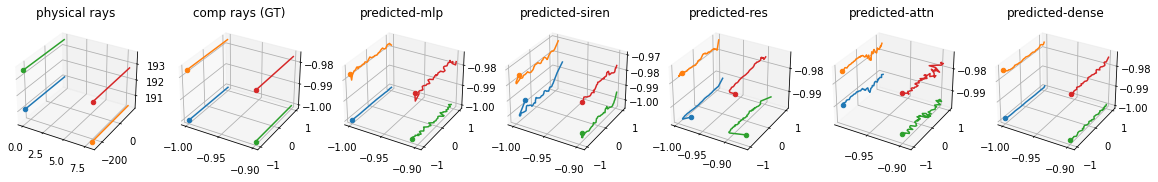

In [161]:
# generate physical rays
print("Grid dimension:", ds.dims)

phys = ds.phys.reshape(*ds.dims, 3)
comp = ds.comp.reshape(*ds.dims, 3)
rays = phys[10:13, :, 20]
comp_rays = comp[10:13, :, 20]

yz_rays = phys[:2, :2, :].reshape(4,-1,3)
xy_rays = phys[:, :2, :2, None].swapaxes(0, -2).squeeze().reshape(4, -1, 3)
xz_rays = phys[:2, :, :2, None].swapaxes(1, -2).squeeze().reshape(4,-1,3)
yz_comp_rays = comp[:2, :2, :].reshape(4,-1,3)
xy_comp_rays = comp[:, :2, :2, None].swapaxes(0, -2).squeeze().reshape(4, -1, 3)
xz_comp_rays = comp[:2, :, :2, None].swapaxes(1, -2).squeeze().reshape(4,-1,3)

planes = ["YZ Plane", "XY Plane", "XZ Plane"]
plane_rays = [yz_rays, xy_rays, xz_rays]
plane_comp_rays = [yz_comp_rays, xy_comp_rays, xz_comp_rays]

for i in range(len(planes)):
  rays = plane_rays[i]
  comp_rays = plane_comp_rays[i]
  print(f"************  from {planes[i]} ************")
  models_infer_plot(rays, comp_rays, ds.inpp, ckpts, names)
  # for i in range(len(models)):
  #   model_infer_plot(rays, comp_rays, ds.inpp, ckpts[i], names[i])


# for i in range(len(rays[0])):
#   print(in_rays[i], out_rays[i])

Grid dimension: [21 51 88]
************  from YZ Plane ************


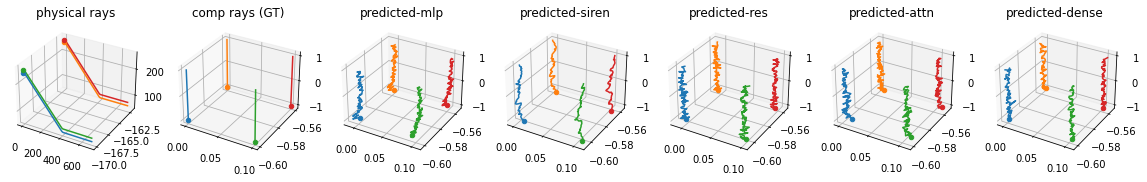

************  from XY Plane ************


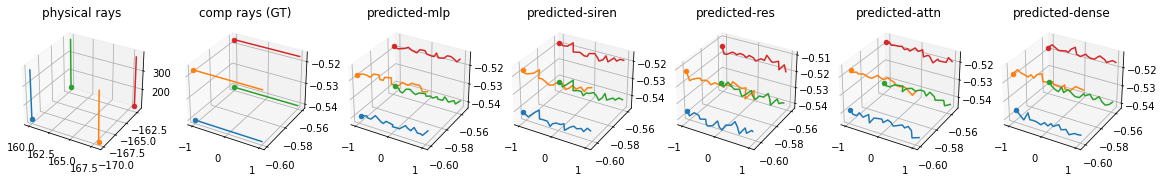

************  from XZ Plane ************


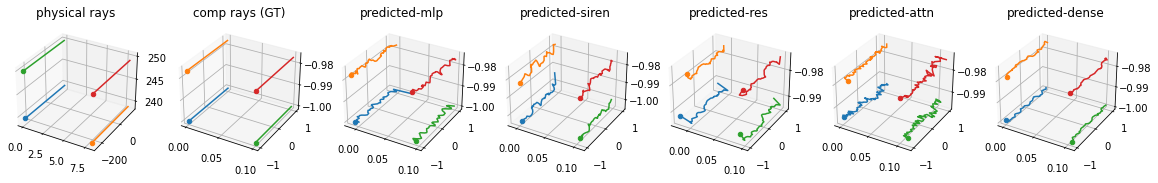

In [165]:
# generate physical rays
print("Grid dimension:", ds.dims)

phys = ds.phys.reshape(*ds.dims, 3)
comp = ds.comp.reshape(*ds.dims, 3)
rays = phys[10:13, :, 20]
comp_rays = comp[10:13, :, 20]

yz_rays = phys[10:12, 10:12, :].reshape(4,-1,3)
xy_rays = phys[:, 10:12, 20:22, None].swapaxes(0, -2).squeeze().reshape(4, -1, 3)
xz_rays = phys[10:12, :, :2, None].swapaxes(1, -2).squeeze().reshape(4,-1,3)
yz_comp_rays = comp[10:12, 10:12, :].reshape(4,-1,3)
xy_comp_rays = comp[:, 10:12, 20:22, None].swapaxes(0, -2).squeeze().reshape(4, -1, 3)
xz_comp_rays = comp[10:12, :, :2, None].swapaxes(1, -2).squeeze().reshape(4,-1,3)

planes = ["YZ Plane", "XY Plane", "XZ Plane"]
plane_rays = [yz_rays, xy_rays, xz_rays]
plane_comp_rays = [yz_comp_rays, xy_comp_rays, xz_comp_rays]

for i in range(len(planes)):
  rays = plane_rays[i]
  comp_rays = plane_comp_rays[i]
  print(f"************  from {planes[i]} ************")
  models_infer_plot(rays, comp_rays, ds.inpp, ckpts, names)

(2, 2)


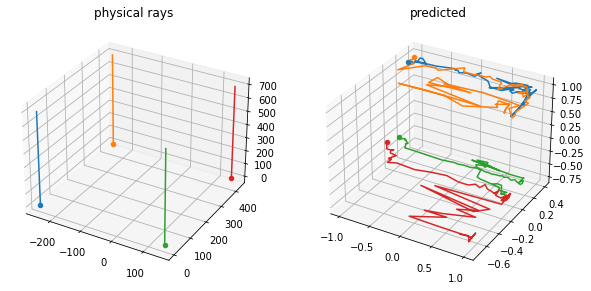

In [182]:
imgSize = 2
numDepths = 64
rays = getRays(imgSize, numDepths, [1,2], vtkSG.GetBounds())
rays = rays.reshape(imgSize*imgSize, numDepths, 3)

in_rays = ds.inpp.transform(rays)
in_rays = torch.Tensor(in_rays)

with torch.no_grad():
  model = ckpts[i]['model']
  model.eval()
  out_rays = model(in_rays)
out_rays = out_rays.cpu().numpy().reshape(rays.shape)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
for ray in rays:
  ax1.scatter(ray[0,0], ray[0,1], ray[0,2])
  ax1.plot(ray[:,0], ray[:,1], ray[:,2])
plt.title(f"physical rays")

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for ray in out_rays:
  ax2.scatter(ray[0,0], ray[0,1], ray[0,2])
  ax2.plot(ray[:,0], ray[:,1], ray[:,2])
plt.title(f"predicted")

plt.show()

In [157]:
tmp = phys[5:15:5, :, 30:50:10, None]
tmp.shape

(2, 51, 2, 1, 3)

In [144]:
xy_rays.shape

(4, 21, 3)

In [138]:
for tmp in plane_rays:
  print(tmp.shape)

(4, 88, 3)
(4, 21, 3)
(4, 51, 3)
